## Project FMST - Solution by Shiva Pingle

Objective : To predict the concrete strength using the data available in file "concrete.csv". 

Apply feature engineering and model tuning to obtain 85% to 95% accuracy.


    
The data for this project is available in file https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/. The same has been shared along with the course content.


In [1]:
# Import important libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor  
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import BaggingRegressor
from scipy.stats import randint as sp_randint


In [2]:
#Functions to be used later

def sanity_check_1(df):
    dtype = df.dtypes
    null = df.isnull().sum()
    unique = df.nunique()

    result_df = pd.concat([dtype, null, unique], axis=1)
    result_df.columns = ['dtype', 'null', 'unique']
    result_df['null_%'] = result_df['null'].values / len(df)
    print(df.info())
    result_df.sort_values(['unique'],inplace=True)
    
    return result_df


def univariate_numerical(df):
    univariate_df = pd.concat([df.describe(percentiles=[i/10 for i in range(1, 10)]).T, df.skew()], axis=1)
    univariate_df.rename(columns={0:"skew"}, inplace=True)
    return univariate_df


def chi_square(data, features, target):
    
    output = dict()
    
    for feature in features:

        data_crosstab = pd.crosstab(data[feature],  
                                    data[target], 
                                        margins = False)

        stat, p, dof, expected = chi2_contingency(data_crosstab)
        
        output[feature] = [stat, p]
    
    return output

def f_values(data, features, target):
    X = data[features].values
    y = data[target].values

    f_values, p_values = f_classif(X, y)
    result = {feature:[f_value, p_value] for feature, f_value, p_value in zip(features, f_values, p_values)}
    return result

In [3]:
#df = pd.read_csv("Dummy_Data_-_Train.csv")
df_freq = pd.read_csv("frequency_domain_features_train.csv")
df_heart = pd.read_csv("heart_rate_non_linear_features_train.csv")
df_time = pd.read_csv("time_domain_features_train.csv")

s1 = sanity_check_1(df_freq)
s2 = sanity_check_1(df_heart)
s3 = sanity_check_1(df_time)
print("Frequence domain features",s1)
print("Heart rate non linear",s2)
print("Time domain features",s3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369289 entries, 0 to 369288
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   uuid     369289 non-null  object 
 1   VLF      369289 non-null  float64
 2   VLF_PCT  369289 non-null  float64
 3   LF       369289 non-null  float64
 4   LF_PCT   369289 non-null  float64
 5   LF_NU    369289 non-null  float64
 6   HF       369289 non-null  float64
 7   HF_PCT   369289 non-null  float64
 8   HF_NU    369289 non-null  float64
 9   TP       369289 non-null  float64
 10  LF_HF    369289 non-null  float64
 11  HF_LF    369289 non-null  float64
dtypes: float64(11), object(1)
memory usage: 33.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369289 entries, 0 to 369288
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   uuid       369289 non-null  object 
 1   SD1        369289 non-null  float64
 2   SD2  

In [4]:
print("df_freq",df_freq.shape)
print("df_heart",df_heart.shape)
print("df_time",df_time.shape)

df_freq (369289, 12)
df_heart (369289, 7)
df_time (369289, 20)


In [5]:
df_merged1 = pd.merge(df_freq,df_heart,how='inner',on='uuid')
df_merged = pd.merge(df_merged1,df_time,how='inner',on='uuid')
print(df_merged1.shape)
print(df_merged.shape)

(369289, 18)
(369289, 37)


In [6]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369289 entries, 0 to 369288
Data columns (total 37 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   uuid               369289 non-null  object 
 1   VLF                369289 non-null  float64
 2   VLF_PCT            369289 non-null  float64
 3   LF                 369289 non-null  float64
 4   LF_PCT             369289 non-null  float64
 5   LF_NU              369289 non-null  float64
 6   HF                 369289 non-null  float64
 7   HF_PCT             369289 non-null  float64
 8   HF_NU              369289 non-null  float64
 9   TP                 369289 non-null  float64
 10  LF_HF              369289 non-null  float64
 11  HF_LF              369289 non-null  float64
 12  SD1                369289 non-null  float64
 13  SD2                369289 non-null  float64
 14  sampen             369289 non-null  float64
 15  higuci             369289 non-null  float64
 16  da

In [7]:
df_merged.nunique()

uuid                 369289
VLF                  369289
VLF_PCT              369289
LF                   369289
LF_PCT               369289
LF_NU                369289
HF                   369289
HF_PCT               369289
HF_NU                369289
TP                   369289
LF_HF                369289
HF_LF                369289
SD1                  369289
SD2                  369289
sampen                82511
higuci               369289
datasetId                 1
condition                 3
MEAN_RR              369289
MEDIAN_RR            106329
SDRR                 369289
RMSSD                369289
SDSD                 369289
SDRR_RMSSD           369289
HR                   369289
pNN25                   592
pNN50                    83
KURT                 369289
SKEW                 369289
MEAN_REL_RR          369289
MEDIAN_REL_RR         25041
SDRR_REL_RR          369289
RMSSD_REL_RR         369289
SDSD_REL_RR          369289
SDRR_RMSSD_REL_RR    369289
KURT_REL_RR         

In [8]:
df_merged.isnull().sum()

uuid                 0
VLF                  0
VLF_PCT              0
LF                   0
LF_PCT               0
LF_NU                0
HF                   0
HF_PCT               0
HF_NU                0
TP                   0
LF_HF                0
HF_LF                0
SD1                  0
SD2                  0
sampen               0
higuci               0
datasetId            0
condition            0
MEAN_RR              0
MEDIAN_RR            0
SDRR                 0
RMSSD                0
SDSD                 0
SDRR_RMSSD           0
HR                   0
pNN25                0
pNN50                0
KURT                 0
SKEW                 0
MEAN_REL_RR          0
MEDIAN_REL_RR        0
SDRR_REL_RR          0
RMSSD_REL_RR         0
SDSD_REL_RR          0
SDRR_RMSSD_REL_RR    0
KURT_REL_RR          0
SKEW_REL_RR          0
dtype: int64

In [9]:
df_merged[['datasetId','HR']].head()

,datasetId,HR
0,2,69.499952
1,2,64.363150
2,2,67.450066
3,2,68.809562
4,2,74.565728


In [10]:
type(df_merged['datasetId'])

pandas.core.series.Series

In [11]:
type(df_merged['TP'])

pandas.core.series.Series

In [12]:
df_merged.drop(['uuid','datasetId'],inplace=True,axis=1)

In [13]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369289 entries, 0 to 369288
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VLF                369289 non-null  float64
 1   VLF_PCT            369289 non-null  float64
 2   LF                 369289 non-null  float64
 3   LF_PCT             369289 non-null  float64
 4   LF_NU              369289 non-null  float64
 5   HF                 369289 non-null  float64
 6   HF_PCT             369289 non-null  float64
 7   HF_NU              369289 non-null  float64
 8   TP                 369289 non-null  float64
 9   LF_HF              369289 non-null  float64
 10  HF_LF              369289 non-null  float64
 11  SD1                369289 non-null  float64
 12  SD2                369289 non-null  float64
 13  sampen             369289 non-null  float64
 14  higuci             369289 non-null  float64
 15  condition          369289 non-null  object 
 16  ME

In [14]:
df_merged['condition'].unique()

array(['no stress', 'interruption', 'time pressure'], dtype=object)

In [15]:
print(df_merged['condition'].unique())
oneHotCols=['condition']
df_merged_final=pd.get_dummies(df_merged,columns=oneHotCols)
#df_merged_final['condition'].head(10)

['no stress' 'interruption' 'time pressure']


In [16]:
df_merged_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369289 entries, 0 to 369288
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   VLF                      369289 non-null  float64
 1   VLF_PCT                  369289 non-null  float64
 2   LF                       369289 non-null  float64
 3   LF_PCT                   369289 non-null  float64
 4   LF_NU                    369289 non-null  float64
 5   HF                       369289 non-null  float64
 6   HF_PCT                   369289 non-null  float64
 7   HF_NU                    369289 non-null  float64
 8   TP                       369289 non-null  float64
 9   LF_HF                    369289 non-null  float64
 10  HF_LF                    369289 non-null  float64
 11  SD1                      369289 non-null  float64
 12  SD2                      369289 non-null  float64
 13  sampen                   369289 non-null  float64
 14  higu

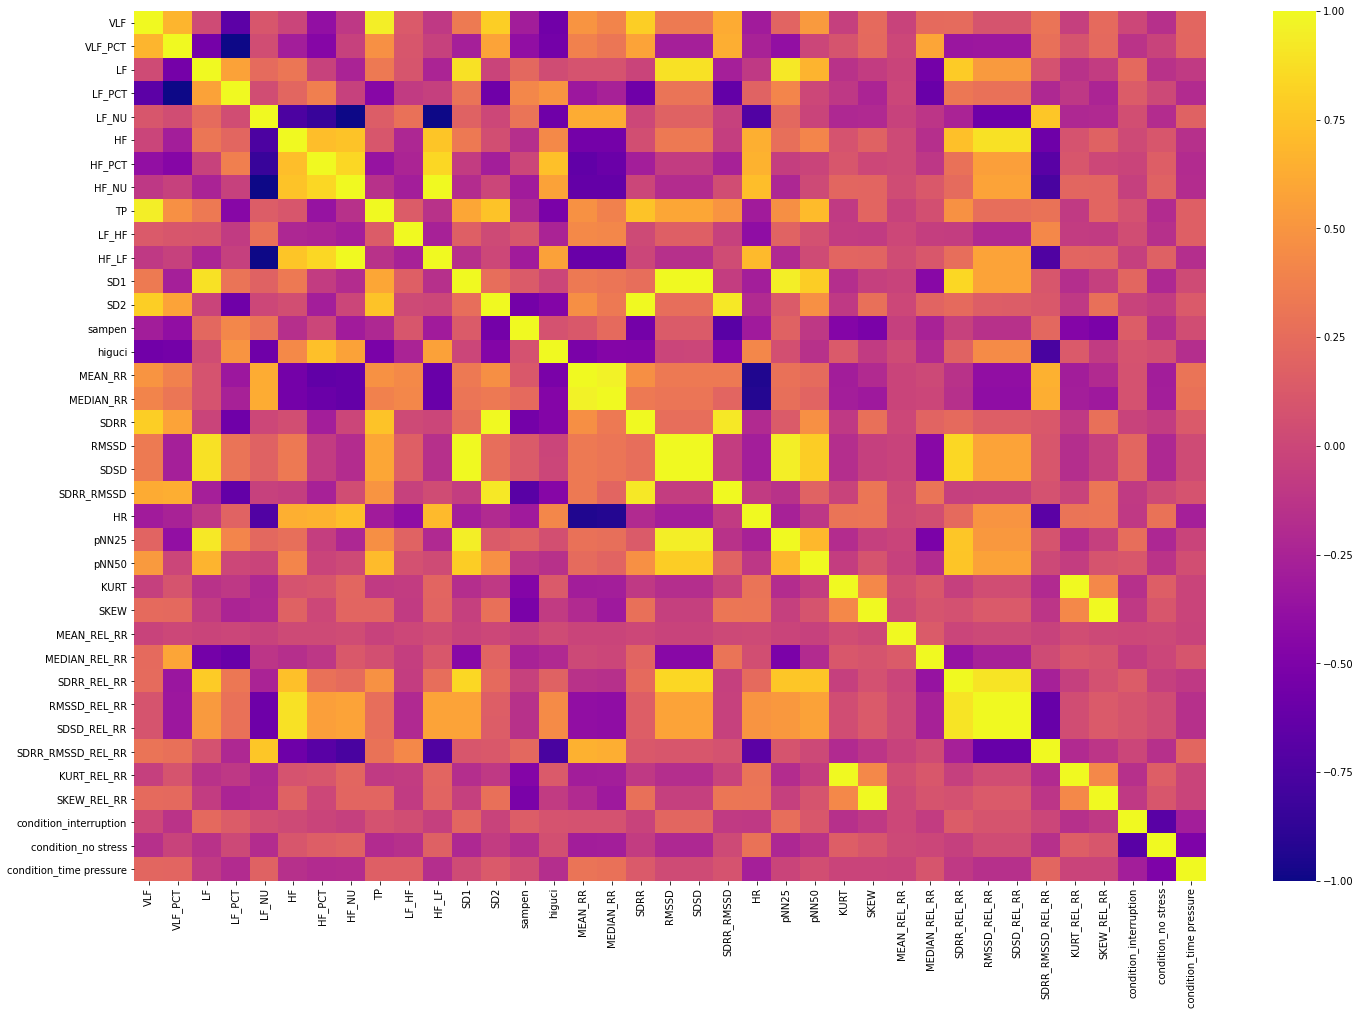

In [17]:
plt.figure(figsize=(24,16))  #setting the figure size
sns.heatmap(df_merged_final.corr(), cmap='plasma')  #heat map to plot the above table
plt.show()

In [18]:
corr = df_merged_final.corr()

In [19]:
X_train =  df_merged_final.drop('HR',axis=1)     # Predictor feature columns 
y_train =  df_merged_final['HR']   # Target column
y_train.head()
print(y_train.shape)
print(type(y_train))

(369289,)
<class 'pandas.core.series.Series'>


In [20]:
from scipy.stats import zscore
X_train_z = X_train.apply(zscore)
y_train_1 = df_merged_final.apply(zscore)

In [21]:
y_train_z = y_train_1['HR']
print(y_train_z.shape)
y_train_z

(369289,)


0        -0.429688
1        -0.926600
2        -0.627985
3        -0.496473
4         0.060354
            ...   
369284    0.913459
369285   -1.221539
369286   -1.442643
369287    0.197032
369288    0.024772
Name: HR, Length: 369289, dtype: float64

In [22]:
X_train_z.columns

Index(['VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU',
       'TP', 'LF_HF', 'HF_LF', 'SD1', 'SD2', 'sampen', 'higuci', 'MEAN_RR',
       'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'pNN25', 'pNN50',
       'KURT', 'SKEW', 'MEAN_REL_RR', 'MEDIAN_REL_RR', 'SDRR_REL_RR',
       'RMSSD_REL_RR', 'SDSD_REL_RR', 'SDRR_RMSSD_REL_RR', 'KURT_REL_RR',
       'SKEW_REL_RR', 'condition_interruption', 'condition_no stress',
       'condition_time pressure'],
      dtype='object')

Index(['VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU',
       'TP', 'LF_HF', 'HF_LF', 'SD1', 'SD2', 'sampen', 'higuci', 'MEAN_RR',
       'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'pNN25', 'pNN50',
       'KURT', 'SKEW', 'MEAN_REL_RR', 'MEDIAN_REL_RR', 'SDRR_REL_RR',
       'RMSSD_REL_RR', 'SDSD_REL_RR', 'SDRR_RMSSD_REL_RR', 'KURT_REL_RR',
       'SKEW_REL_RR', 'condition_interruption', 'condition_no stress',
       'condition_time pressure'],
      dtype='object')
0


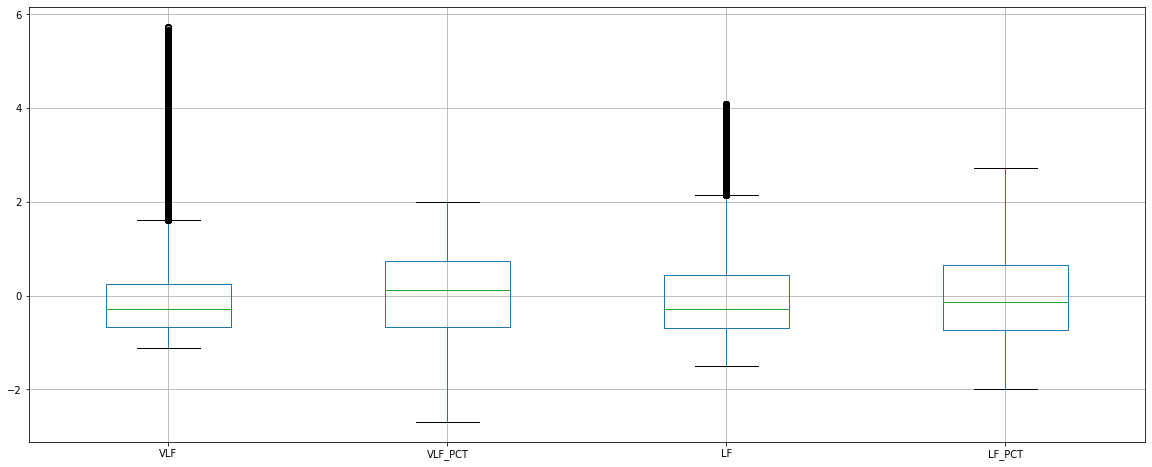

4


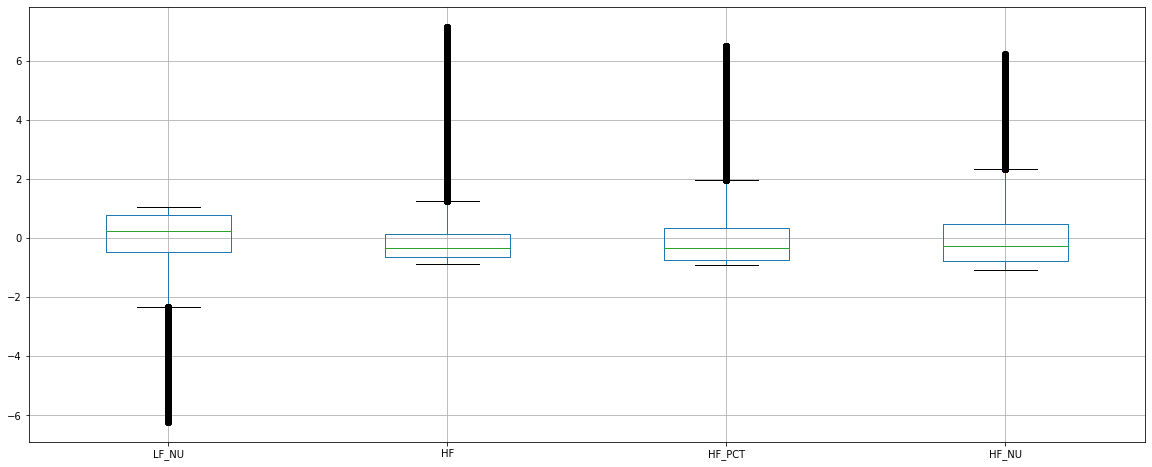

8


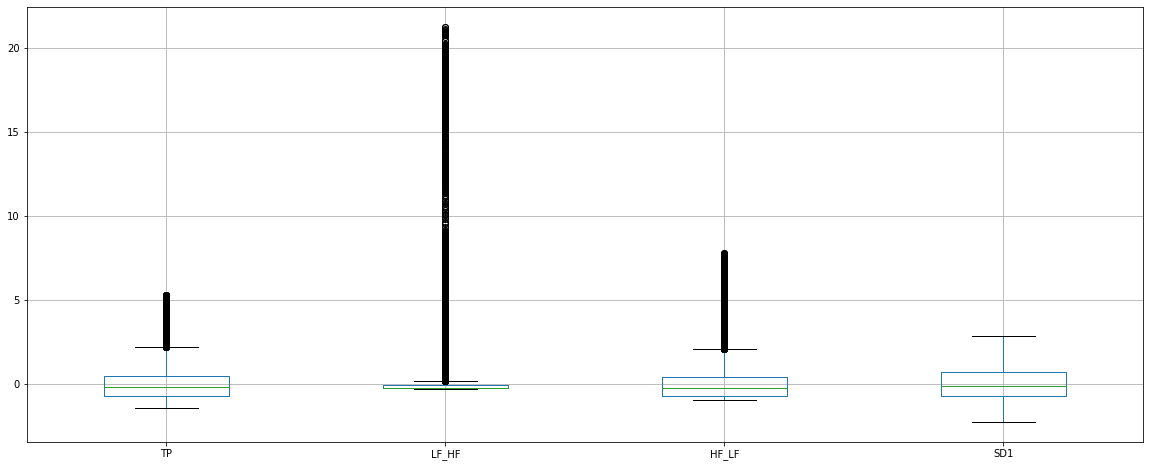

12


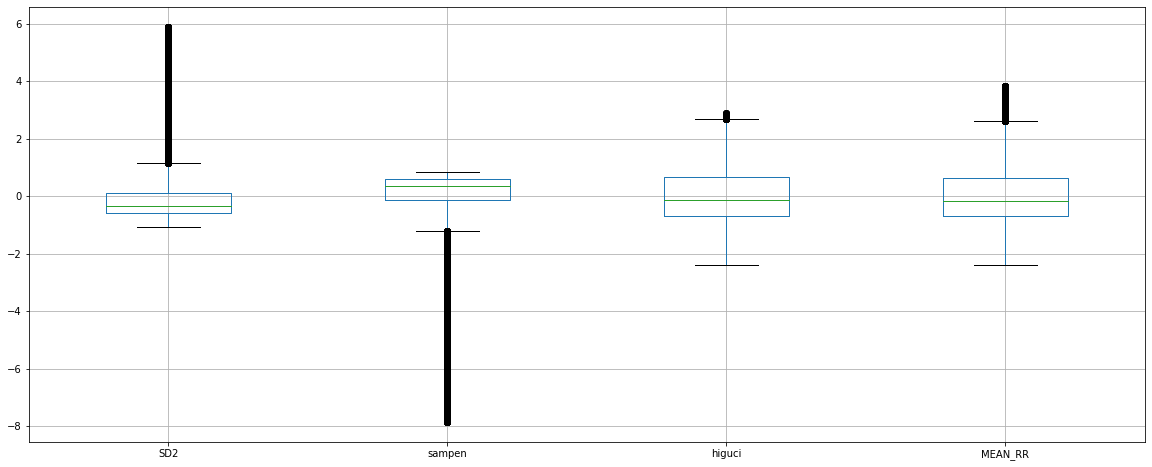

16


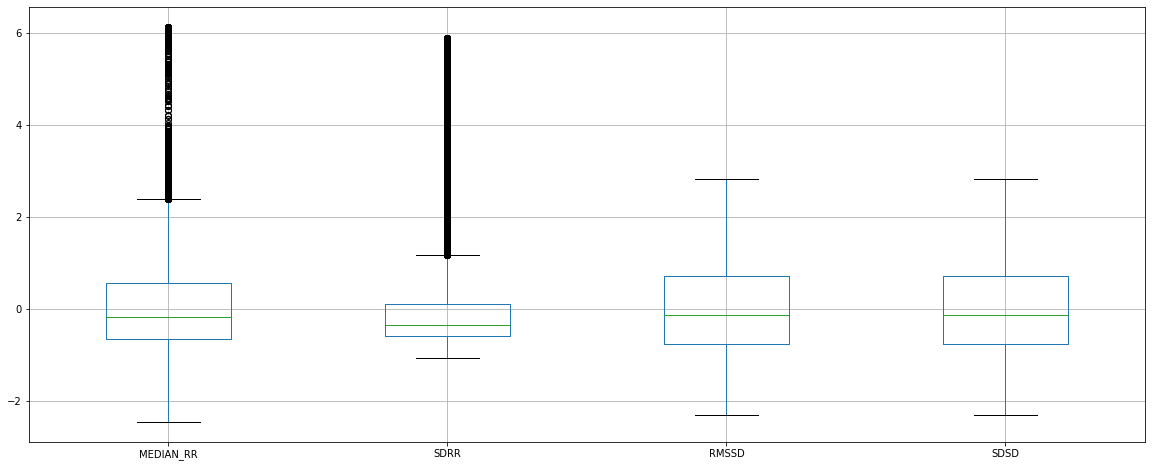

20


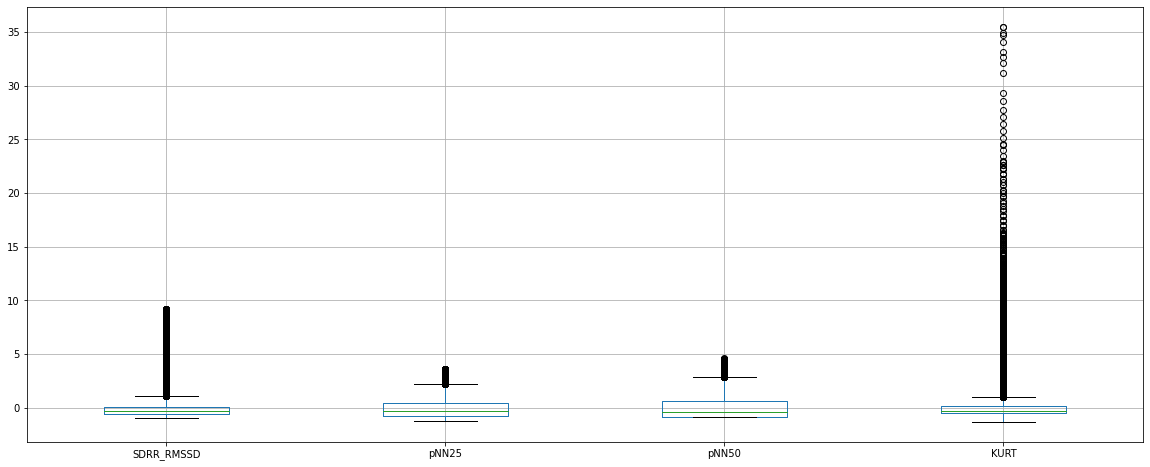

24


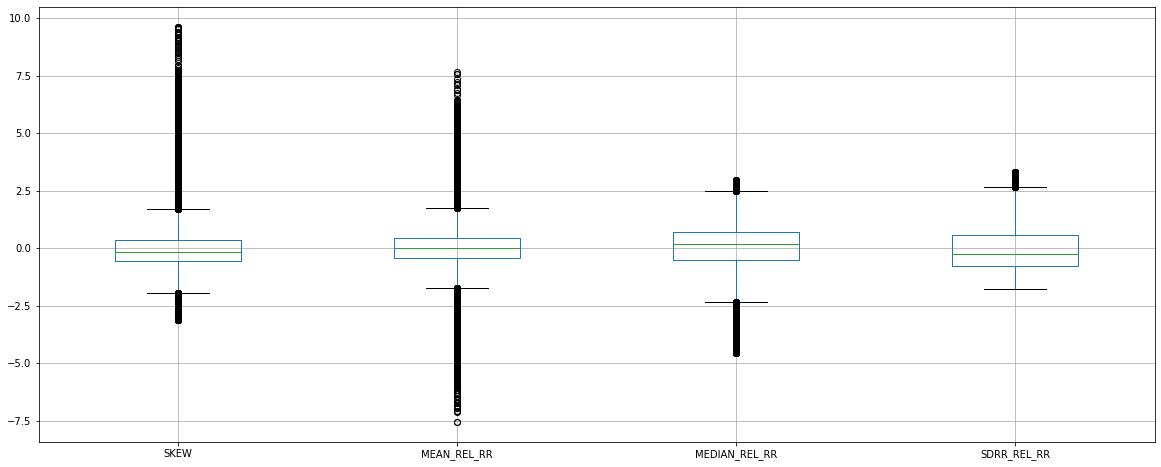

28


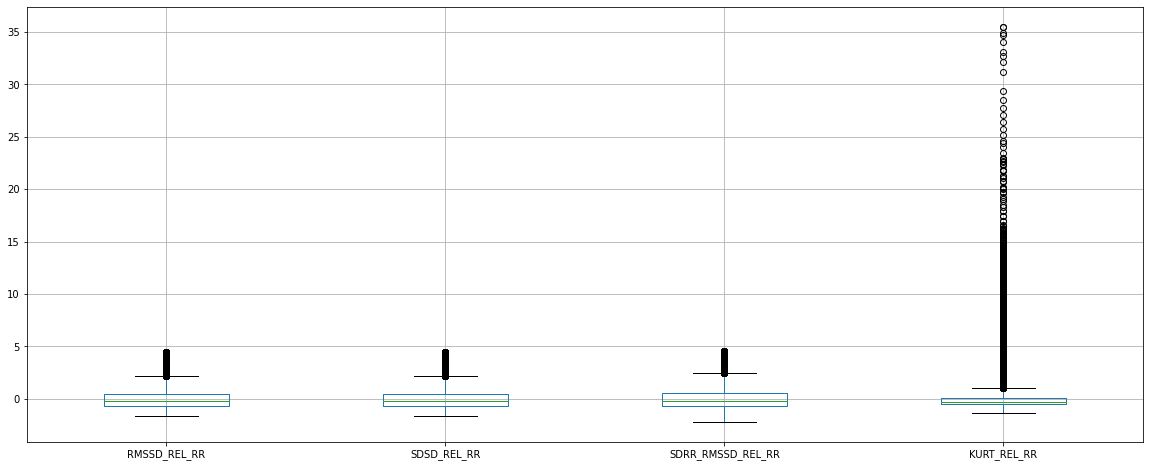

32


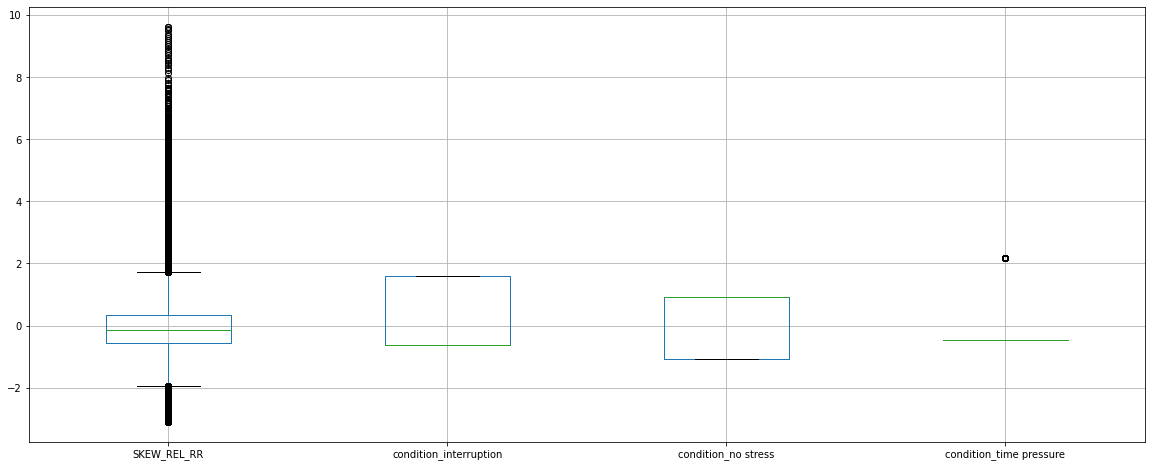

<Figure size 432x288 with 0 Axes>

In [23]:
print(X_train_z.columns)
for i in np.arange(0,36,4):
    print(i)
    X_train_z[[X_train_z.columns[i],X_train_z.columns[i+1],X_train_z.columns[i+2],X_train_z.columns[i+3]]].boxplot(figsize=(20,8))
    plt.show()
plt.tight_layout()

In [24]:
#df_z.columns

NameError: name 'df_z' is not defined

In [25]:
covMatrix = np.cov(X_train_z,rowvar=False)
print(covMatrix)

[[ 1.00000271  0.67662983  0.0265213  ...  0.00242999 -0.16311397
   0.21174151]
 [ 0.67662983  1.00000271 -0.54197741 ... -0.13978593 -0.02830262
   0.20384696]
 [ 0.0265213  -0.54197741  1.00000271 ...  0.22897995 -0.1419873
  -0.08607273]
 ...
 [ 0.00242999 -0.13978593  0.22897995 ...  1.00000271 -0.68609523
  -0.28903991]
 [-0.16311397 -0.02830262 -0.1419873  ... -0.68609523  1.00000271
  -0.49815477]
 [ 0.21174151  0.20384696 -0.08607273 ... -0.28903991 -0.49815477
   1.00000271]]


In [26]:
X_train_z.shape

(369289, 36)

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=36)
pca.fit(X_train_z)
#ata_reduced = pca.fit_transform(df_z)
#ata_reduced.transpose()

PCA(n_components=36)

In [28]:
print(pca.explained_variance_)

[8.95514737e+00 8.59045139e+00 6.38203854e+00 2.52872748e+00
 1.61759654e+00 1.37484796e+00 1.10966909e+00 9.84259700e-01
 9.69844960e-01 9.39974889e-01 6.07348505e-01 4.98624171e-01
 3.70955961e-01 2.46314907e-01 2.26131542e-01 2.08503797e-01
 1.08853012e-01 8.73192444e-02 5.64264279e-02 4.49027518e-02
 3.08241152e-02 2.52260694e-02 1.43473757e-02 1.32797156e-02
 6.09043022e-03 2.39124561e-03 1.59537536e-07 1.20738169e-07
 4.17385151e-11 4.55998131e-29 1.95914281e-29 7.63825129e-30
 7.59862682e-30 2.97726804e-30 2.72279626e-30 9.48465629e-31]


In [29]:
print(pca.components_)

[[-1.44352833e-01 -1.96144306e-01  8.14806907e-02 ...  1.22572229e-02
   6.76023625e-02 -1.03565105e-01]
 [-1.75376313e-01  4.09980640e-02 -2.80403739e-01 ... -7.98775375e-02
   9.12653658e-02 -2.48916141e-02]
 [ 2.47996104e-01  2.72554804e-01 -1.48238535e-01 ... -7.59340736e-02
   5.39392173e-02  1.95249269e-02]
 ...
 [ 0.00000000e+00  6.55058406e-01 -5.83734450e-16 ...  1.60227701e-02
   1.76900831e-02  1.34435829e-02]
 [-0.00000000e+00 -2.44096089e-02  6.32767493e-16 ... -1.61275653e-02
  -1.78057831e-02 -1.35315091e-02]
 [-0.00000000e+00 -2.94536807e-01  1.72951931e-15 ... -1.01244801e-02
  -1.11780231e-02 -8.49474130e-03]]


In [30]:
print(pca.explained_variance_ratio_)

[2.48753420e-01 2.38623004e-01 1.77278368e-01 7.02422398e-02
 4.49331155e-02 3.81901178e-02 3.08240581e-02 2.73404732e-02
 2.69400648e-02 2.61103429e-02 1.68707461e-02 1.38506339e-02
 1.03043043e-02 6.84206221e-03 6.28141472e-03 5.79175646e-03
 3.02368658e-03 2.42552800e-03 1.56739653e-03 1.24729528e-03
 8.56223104e-04 7.00722252e-04 3.98537136e-04 3.68879989e-04
 1.69178159e-04 6.64233094e-05 4.43158621e-09 3.35382896e-09
 1.15940006e-12 1.26665805e-30 5.44204863e-31 2.12173072e-31
 2.11072396e-31 8.27016661e-32 7.56330246e-32 2.63461961e-32]


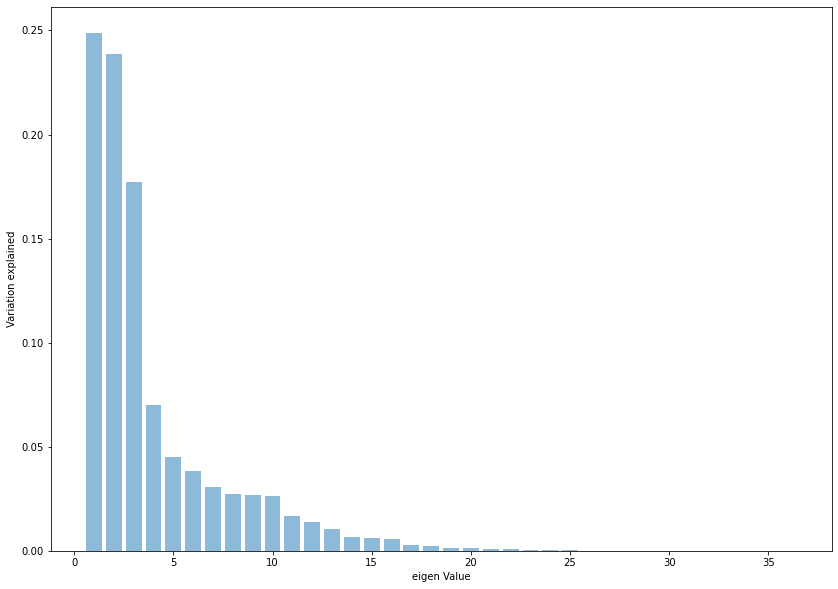

In [31]:
plt.figure(figsize=(14,10)) 
plt.bar(list(range(1,37)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

In [32]:
n_comp = 12
np.sum(pca.explained_variance_ratio_[0:n_comp])

0.9599565841312381

In [33]:
pca.explained_variance_ratio_.shape

(36,)

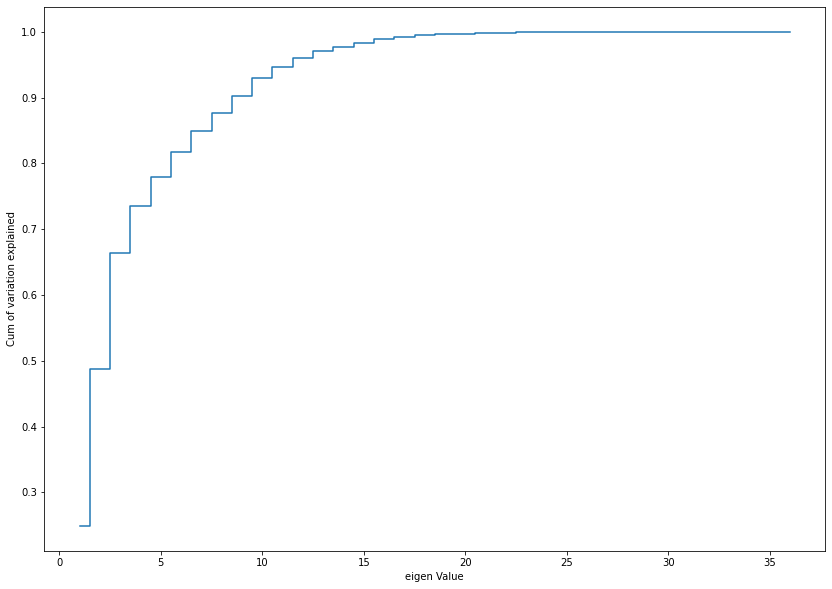

In [34]:
plt.figure(figsize=(14,10)) 
plt.step(list(range(1,37)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [35]:
n_comp=12
pca12 = PCA(n_components=n_comp)
pca12.fit(X_train_z)
#print(pca12.components_)
print(pca12.explained_variance_ratio_)
print(np.sum(pca12.explained_variance_ratio_[0:n_comp]))
Xpca12 = pca12.transform(X_train_z)
print(Xpca12.shape)

[0.24875342 0.238623   0.17727837 0.07024224 0.04493312 0.03819012
 0.03082406 0.02734047 0.02694006 0.02611034 0.01687075 0.01385063]
0.9599565841312316
(369289, 12)


# Gradient Boost Regressor

In [36]:
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [37]:
params_GBR = {'loss': 'ls',
          'learning_rate': 0.03,
          'n_estimators': 50,
          'subsample': 0.8,
          'max_depth': 10,
          'max_features': 0.3,
          'min_impurity_decrease': 1e-10,
          'min_samples_leaf': 5
         }

In [38]:
print('Gradient Boost Model')
reg = gbr(random_state=98,**params_GBR)
reg.fit(Xpca12, y_train)
y_pred = reg.predict(Xpca12)

Gradient Boost Model


In [39]:
nrmse = np.sqrt(mean_squared_error(y_train, y_pred)) / np.mean(y_train)
nrmse

0.03470435639350449

In [40]:
MAE_error = np.sum(abs(y_pred-y_train))/(y_train.shape[0])
MAE_error

2.0154047994070963

In [41]:
MAE_error

2.0154047994070963

In [42]:
np.mean(y_train)

73.94182397352273

In [43]:
n_rows = 10000
#Xpca12_nrows=Xpca12.iloc

In [44]:
print(y_pred[0:20])

[69.56568994 66.97302754 69.48870999 69.67494712 74.05775308 79.76968465
 65.42128067 83.11066971 74.55165758 65.23802746 71.70477345 67.46273052
 83.88871964 77.41808908 74.24126918 93.31939151 68.35532596 79.071357
 76.21492148 75.81619681]


In [45]:
print(y_train[0:20])

0     69.499952
1     64.363150
2     67.450066
3     68.809562
4     74.565728
5     81.342254
6     62.095066
7     85.857703
8     74.588857
9     62.726998
10    71.040116
11    65.443870
12    87.103763
13    77.996914
14    74.433094
15    99.328670
16    66.594255
17    80.961985
18    77.604869
19    74.884631
Name: HR, dtype: float64


In [46]:
MAE_trial = y_train[0:20]-y_pred[0:20]
MAE_trial

0    -0.065738
1    -2.609878
2    -2.038644
3    -0.865385
4     0.507974
5     1.572569
6    -3.326215
7     2.747034
8     0.037199
9    -2.511030
10   -0.664658
11   -2.018861
12    3.215043
13    0.578825
14    0.191825
15    6.009279
16   -1.761071
17    1.890628
18    1.389947
19   -0.931566
Name: HR, dtype: float64

In [50]:
regression_model = LinearRegression()
regression_model.fit(Xpca12, y_train)

#for idx, col_name in enumerate(Xpca12.columns):
#    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

LinearRegression()

In [54]:
#intercept = regression_model.intercept_[0]

#print("The intercept for our model is {}".format(intercept))
#intercept

In [55]:
y_pred = regression_model.predict(Xpca12) 

In [56]:
print(y_pred[0:20])

[ 69.57004866  67.52272834  69.0738867   68.45189413  72.10840629
  85.03368166  65.84594106  89.62492421  75.44188515  65.14326228
  72.23992621  68.15234224  83.47713327  77.47682216  72.40402713
 101.41753125  67.22350053  80.84424365  78.75861632  77.07310878]


In [57]:
MAE_error = np.sum(abs(y_pred-y_train))/(y_train.shape[0])
MAE_error

1.7428163794351383

In [58]:
nrmse = np.sqrt(mean_squared_error(y_train, y_pred)) / np.mean(y_train)
nrmse

0.032639112878180825

In [ ]:


## Plot deviance
deviance(reg, X_test, y_test, plot=True)
#Model scores
nrmse = np.sqrt(mean_squared_error(y_test, y_pred)) / np.mean(y_test)
print("R^2 score on training data: {}".format(reg.score(X_train,y_train)))
print("R^2 score on holdout test data: {}".format(reg.score(X_test,y_test)))
print("Holdout loss: {}, NRSME: {}".format(reg.loss_(y_test,y_pred),nrmse))

plt.figure(figsize=(5,5))
plt.plot(np.linspace(0,200,10),np.linspace(0,200,10),'-k')
plt.scatter(y_test, y_pred, s=2)
plt.xlabel('test');plt.ylabel('prediction'),plt.title('GHF (Predictied vs Test)')
plt.grid();plt.xlim(20,140);plt.ylim(20,140)

In [ ]:
df_comp = pd.DataFrame(pca.components_,columns=list(df_z))
df_comp.head()
print(df_comp.shape)

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

No Null values. 8 Quantitative, continuous features.

In [ ]:
df_heart['condition'].unique()

In [ ]:
all_cols = s1.index.tolist()
numeric_cols = s1.index.tolist()
print(numeric_cols)
numeric_cols.remove('strength')
print(numeric_cols)

In [ ]:
univariate_numerical(df_freq).T

In [ ]:
univariate_numerical(df_heart).T

In [ ]:
univariate_numerical(df_time).T

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(df_time['HR'],bins=2000)

In [ ]:
for i in all_cols:
    fig, axes = plt.subplots(2,1,figsize=(8,6))
    axes[0].boxplot(df[i],flierprops=dict(markerfacecolor='r',marker='D'),vert=False)
    sns.distplot(df[i],bins=20)

Conclusion from Boxplots - 'age', 'superplastic' features and 'strength' output variable have outliers on the higher side.


* Cement is normally distributed. 
* Slag has three gausssians and rightly skewed. 
* Ash has two gaussians and rightly skewed. 
* Water has three guassians and slighly left skewed. 
* Superplastic has two gaussians and rightly skewed. 
* Coarseagg has three guassians and almost normal. 
* Fineagg has almost two guassians and looks like normal. 
* Age has multiple guassians and rightly skewed.

In [ ]:

fig, axes = plt.subplots(3,3, figsize=(15,12))

for i,feat in enumerate(numeric_cols):
    sns.scatterplot(x=feat,y='strength',data=df,ax=axes.flatten()[i])
plt.tight_layout()



Relationship between independent columns * 

* Except the cement column no other columns have found to have a visible linear relationship with the strength column. 

* The columns coarseagg and fineagg seems to have slight positive linear relationship.
The presence of outliers are seen between columns slag and ash and as well as cement and ash 
* The presence of outliers are seen between columns fineagg and ash and as well as coarseagg and ash  
* The presence of outliers are seen between columns water and ash 
The presence of outliers are seen between column superplastic and the columns cement, slag, coarseagg, and fineagg * 
* It is clearly seen that most of the columns do not have any linear relationship between them. Relationship between target and independent columns * 
There seems to be a linear relationship between cement and strength column 
* There are outliers found between cement and ash columns 
Relationship between Independent attributes/variables:-
* Majority of the independent attributes does not have any significant relationship with other independent attributes. "superplastic" and "water" display negative/inverse relationship. "fineagg" and "water" display negative/inverse relationship. Relationship between Independent attributes and dependent/target variable "strength" vs "cement": It is linearly related to the cement. The relationship is positive. This could be good predictor "strength" vs "superplastic": Some amount of positive trend / relationship. "strength vs other attributes: 
*None of the other attributes display any significant relationship with strength variable.



In [ ]:
print("Age feature has only {} unique values. The pie chart of those values is shown here.".format(df['age'].nunique()))
plt.figure(figsize=(8,8))
df['age'].value_counts().plot(kind='pie',autopct='%1.0f%%') # Pie chart representation of different Races of people.

In [ ]:
plt.figure(figsize=(14,14))
sns.heatmap(df.corr(),vmin=-1,vmax=1,annot=True,cmap="Greens") # It will show correlation matrix 

'age' and 'superplastic' and 'cement' are weakly correlated to the target variable 'strength'. 

# Linear Regression, Ridge and Lasso Algorithms with Polynomial Features

In [ ]:
X = df[numeric_cols]
y = df[['strength']]
resultsDf = []

In [ ]:
poly = PolynomialFeatures(3, include_bias=False)
X_poly = poly.fit_transform(X)
print(X_poly.shape)

In [ ]:
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.25,random_state=42)

In [ ]:
ln_regression = LinearRegression()
ln_regression.fit(X_train_poly, y_train)

y_pred_reg1 = ln_regression.predict(X_test_poly) 

score1 = ln_regression.score(X_train_poly, y_train)
nrmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_reg1)) / np.mean(y_test)

print('Linear Regression')
print()
print('R^2 Coefficient for Train data: %.4f'% score1)
print('R^2 Coefficient for Test data: %.4f'% r2_score(y_test, y_pred_reg1))

resultsDf = pd.DataFrame({'Method':['Linear Regression'],'PolynomialFeatures(Y/N)':['Yes'], 'R2 Score Training': score1, 'R2 Score Test': r2_score(y_test, y_pred_reg1),'NRMSE':nrmse_lr})
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]

In [ ]:
ridge = Ridge(alpha=0.0100)
ridge.fit(X_train_poly,y_train)
y_pred_reg_Ridge = ridge.predict(X_test_poly) 
score3 = ridge.score(X_train_poly,y_train)
nrmse_Ridge = np.sqrt(mean_squared_error(y_test, y_pred_reg_Ridge)) / np.mean(y_test)
print('Ridge Regression')
print()

print('Ridge Regression: R^2 Coefficient for Train data: %.4f'% score3)
print('Ridge Regression: R^2 Coefficient for Test data: %.4f'% r2_score(y_test, y_pred_reg_Ridge))

tempResultsDf = pd.DataFrame({'Method':['Ridge Regression'],'PolynomialFeatures(Y/N)':['Yes'] ,'R2 Score Training': score3, 'R2 Score Test': r2_score(y_test, y_pred_reg_Ridge),'NRMSE':nrmse_Ridge})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]

In [ ]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_poly,y_train)
y_pred_reg_Lasso = lasso.predict(X_test_poly)
score4 = lasso.score(X_train_poly,y_train)
nrmse_Lasso = np.sqrt(mean_squared_error(y_test, y_pred_reg_Lasso)) / np.mean(y_test)
print('Lasso Regression')
print()
print('Lasso Regression: R^2 Coefficient for Train data: %.4f'% score4)
print('Lasso Regression: R^2 Coefficient for Test data: %.4f'% r2_score(y_test, y_pred_reg_Lasso))


tempResultsDf = pd.DataFrame({'Method':['Lasso Regression'],'PolynomialFeatures(Y/N)':['Yes'] ,'R2 Score Training': score4, 'R2 Score Test': r2_score(y_test, y_pred_reg_Lasso),'NRMSE':nrmse_Lasso})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]

# Decision Tree Regressor

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

In [ ]:
# create a regressor object 
DT_regressor = DecisionTreeRegressor()
DT_regressor.fit(X_train, y_train) 
y_pred = DT_regressor.predict(X_test) 
score1 = DT_regressor.score(X_train, y_train)
nrmse_DT = np.sqrt(mean_squared_error(y_test, y_pred)) / np.mean(y_test)
print('R^2 of the prediction - Training Data: %.3f'%score1)
print('R^2 of the prediction - Testing Data %.3f'% r2_score(y_test, y_pred))
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, y_pred, edgecolors=(1,1,1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=4)
ax.set_xlabel('Actual Strength')
ax.set_ylabel('Predicted Strength')
ax.set_title("Decision Tree Regressor")
plt.show()
#print(DT_regressor.get_params)


tempResultsDf = pd.DataFrame({'Method':['Decision Tree Regressor'],'PolynomialFeatures(Y/N)':['No'] ,'R2 Score Training': score1, 'R2 Score Test': r2_score(y_test, y_pred),'NRMSE':nrmse_DT})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]

In [ ]:
importances = DT_regressor.feature_importances_
indices = np.argsort(importances)
features = X.columns
print("The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.")
plt.figure(figsize=(10,5))
plt.title('Feature Importances - Decision Tree Regressor')
plt.barh(range(len(indices)), importances[indices], color='k', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

# Gradient Boost Regressor

In [ ]:
#params_GBR = {'loss': 'ls','learning_rate': 0.03,'n_estimators': 200,'subsample': 0.8,'max_depth': 64,
#              'max_features': 0.3,'min_impurity_decrease': 1e-10,'min_samples_leaf': 5}
print('Boosting Regressor Model')

reg_gbr = GradientBoostingRegressor(random_state=98)
reg_gbr.fit(X_train, y_train)
y_pred_GBR = reg_gbr.predict(X_test)
nrmse_GBR = np.sqrt(mean_squared_error(y_test, y_pred_GBR)) / np.mean(y_test)
score5 = reg_gbr.score(X_train, y_train)
print("R^2 score on training data: {}".format(reg_gbr.score(X_train,y_train)))
print("R^2 score on test data: {}".format(reg_gbr.score(X_test,y_test)))
print("Normalised mean sqared error: {}".format(nrmse_GBR))

plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,100,10),np.linspace(0,100,10),'-k')
plt.scatter(y_test, y_pred_GBR, s=10)
plt.xlabel('Actual Strength');plt.ylabel('Predicted Strength'),plt.title('(Predicted vs Test (Gradient Boost Regressor))')
plt.grid();plt.xlim(0,80);plt.ylim(0,80)
#print(reg_gbr.get_params())



tempResultsDf = pd.DataFrame({'Method':['Gradient Boost Regressor'],'PolynomialFeatures(Y/N)':['No'],'R2 Score Training': score5, 'R2 Score Test': r2_score(y_test, y_pred_GBR),'NRMSE':nrmse_GBR})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]

In [ ]:
print('Bagging Regressor Model')
reg_bgr = BaggingRegressor(random_state=98)
reg_bgr.fit(X_train, y_train)
y_pred_BGR = reg_bgr.predict(X_test)
score6 = reg_bgr.score(X_train, y_train)
nrmse_BGR = np.sqrt(mean_squared_error(y_test, y_pred_BGR)) / np.mean(y_test)
print("R^2 score on training data: {}".format(reg_bgr.score(X_train,y_train)))
print("R^2 score on test data: {}".format(reg_bgr.score(X_test,y_test)))
print("Normalised mean squared error: {}".format(nrmse_BGR))

plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,200,10),np.linspace(0,200,10),'-k')
plt.scatter(y_test, y_pred_BGR, s=10)
plt.xlabel('Actual Strength');plt.ylabel('Predicted Strength'),plt.title('(Predicted vs Test (Bagging Regressor))')
plt.grid();plt.xlim(0,80);plt.ylim(0,80)
#print(reg_bgr.get_params())

tempResultsDf = pd.DataFrame({'Method':['Bagging Regressor'],'PolynomialFeatures(Y/N)':['No'],'R2 Score Training': score6, 'R2 Score Test': r2_score(y_test, y_pred_BGR),'NRMSE':nrmse_BGR})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]

In [ ]:
resultsDf.reset_index(inplace=True)
resultsDf.drop(['index'], axis=1,inplace=True)
resultsDf = resultsDf.round(3)
resultsDf

Performance metrics for 3 linear regression methods and 3 Decision tree based regression methods are reported in this table. NRMSE - Normalised root mean square error (RMSE normalised by mean of Y_Test). Polynomial Features are used for Linar regresison, Ridge and Lasso regression only. Raw features are input in the decision tree based regressors.

# Cross-Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
resultsDf_CV = []

num_folds = 20
seed = 7
print("Cross-validation for Linear Regression")
kfold = KFold(n_splits = num_folds,random_state=7)
ln_regression = LinearRegression()
res_CV_ln_regression = cross_val_score(ln_regression,X,y,cv=kfold)

R2_Score_LR_CV = res_CV_ln_regression.mean()
stddev_LR_CV = res_CV_ln_regression.std()

resultsDf_CV = pd.DataFrame({'Method':['Linear Regression'],'R2 Score after CV': R2_Score_LR_CV.round(3), 'Standard Dev': stddev_LR_CV.round(3)})
resultsDf_CV = resultsDf_CV[['Method','R2 Score after CV', 'Standard Dev']]

In [ ]:
print("Cross-validation for Decision Tree Regressor")
kfold = KFold(n_splits = num_folds,random_state=7)

DT_regressor = DecisionTreeRegressor()

res_CV_DT = cross_val_score(DT_regressor,X,y,cv=kfold)


R2_Score_DT = res_CV_DT.mean()
stddev_DT = res_CV_DT.std()

tempResultsDf_CV = pd.DataFrame({'Method':['Decision Tree Regressor'],'R2 Score after CV': R2_Score_DT.round(3), 'Standard Dev': stddev_DT.round(3)})
resultsDf_CV = pd.concat([resultsDf_CV, tempResultsDf_CV])
resultsDf_CV = resultsDf_CV[['Method','R2 Score after CV', 'Standard Dev']]


In [ ]:
print("Cross-validation for Bagging Regressor")
kfold = KFold(n_splits = num_folds,random_state=7)

reg_bgr = BaggingRegressor(random_state=98)

res_CV_bgr = cross_val_score(reg_bgr,X,y,cv=kfold)


R2_Score_bgr = res_CV_bgr.mean()
stddev_bgr = res_CV_bgr.std()

tempResultsDf_CV = pd.DataFrame({'Method':['Bagging Regressor'],'R2 Score after CV': R2_Score_bgr.round(3), 'Standard Dev': stddev_bgr.round(3)})
resultsDf_CV = pd.concat([resultsDf_CV, tempResultsDf_CV])
resultsDf_CV = resultsDf_CV[['Method','R2 Score after CV', 'Standard Dev']]


In [ ]:
print("Cross-validation for Gradient Boost Regressor")
kfold = KFold(n_splits = num_folds,random_state=7)

reg_gbr = GradientBoostingRegressor(random_state=98)

res_CV_gbr = cross_val_score(reg_gbr,X,y,cv=kfold)


R2_Score_gbr = res_CV_gbr.mean()
stddev_gbr = res_CV_gbr.std()


tempResultsDf_CV = pd.DataFrame({'Method':['Gradient Boost Regressor'],'R2 Score after CV': R2_Score_gbr.round(3), 'Standard Dev': stddev_gbr.round(3)})
resultsDf_CV = pd.concat([resultsDf_CV, tempResultsDf_CV])
resultsDf_CV = resultsDf_CV[['Method','R2 Score after CV', 'Standard Dev']]


In [ ]:
resultsDf_CV.reset_index(inplace=True)
resultsDf_CV.drop(['index'], axis=1,inplace=True)
print("This table is obtained by Cross-validation for Bagging Regressor")
resultsDf_CV

Cross-Validation  - The R2 score is the mean of the array containing cross validation scores. The R2 score and standard deviation are derived from the cross validation score array and reported. The score deteriorates with increasing "num_folds" value.

# Using  RandomizedSearchCV() for finding optimum parameteres

In [ ]:
print("Find out the best parameters for the Gradient Boost Regressor.")
GBR_dict = {'learning_rate': np.arange(0.1,0.3,0.05),
          'n_estimators': np.arange(10,300,50),
          'subsample': [0.5,1],
          'max_depth': np.arange(2,10,2),
          'max_features': np.arange(0.25,1,0.25),
          'min_impurity_decrease': [0,0.1,1e-10,1e-20],
          'min_samples_leaf': np.arange(5,25,5)
             }
tic = time.time()
reg_gbr = GradientBoostingRegressor()
gbr_RandomCV = RandomizedSearchCV(reg_gbr, param_distributions=GBR_dict,cv=15,n_iter=150,n_jobs=2)
gbr_RandomCV.fit(X, y)
toc = time.time()

print('Best Test Score:',gbr_RandomCV.best_score_.round(2))
print("Time taken in seconds:",(toc-tic))


best_params_GBR = gbr_RandomCV.best_params_
print('Best parameters:',best_params_GBR)


print('Boosting Regressor Model with Best parameters obtained from RandomizedSearchCV')
print()
print()
reg_gbr1 = GradientBoostingRegressor(random_state=98,**best_params_GBR)
reg_gbr1.fit(X_train, y_train)
y_pred_GBR = reg_gbr1.predict(X_test)
nrmse_GBR1 = np.sqrt(mean_squared_error(y_test, y_pred_GBR)) / np.mean(y_test)
score_GBR_CV = reg_gbr1.score(X_train, y_train)
print("R^2 score on training data: {}".format(reg_gbr1.score(X_train,y_train)))
print("R^2 score on test data: {}".format(reg_gbr1.score(X_test,y_test)))
print("Normalised mean sqared error: {}".format(nrmse_GBR1))


tempResultsDf = pd.DataFrame({'Method':['Gradient Boost Regressor (RandomizedSearchCV)'],'PolynomialFeatures(Y/N)':['No'],'R2 Score Training': score_GBR_CV, 'R2 Score Test': r2_score(y_test, y_pred_BGR),'NRMSE':nrmse_GBR1})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]


In [ ]:
print("Find out the best parameters for the Decision Tree Regressor Regressor.")

from scipy.stats import randint as sp_randint

DT_dict = {"max_depth": np.arange(100,300,1),
              "min_samples_split": sp_randint(1,10),
              "min_samples_leaf": sp_randint(1,10),
              'criterion':['mse','mae'],
             'min_weight_fraction_leaf':[0.001,0.0015,0.0016,0.002,0.0021,0.01],           
            }
tic = time.time()
DT_regressor = DecisionTreeRegressor()
DT_RandomCV = RandomizedSearchCV(DT_regressor, param_distributions=DT_dict,cv=10,n_iter=50,n_jobs=2)
DT_RandomCV.fit(X, y)
toc = time.time()
print('Best Test Score:',DT_RandomCV.best_score_.round(2))
print("Time taken in seconds:",(toc-tic))
DT_params = DT_RandomCV.best_params_
print("Best Parameters are:\n",DT_params)
print()
print()

DT_regressor1 = DecisionTreeRegressor(**DT_params)
# fit the regressor with X and Y data 
DT_regressor1.fit(X_train, y_train) 
y_pred = DT_regressor1.predict(X_test) 
score_DT_CV = DT_regressor1.score(X_train, y_train)
nrmse_DT = np.sqrt(mean_squared_error(y_test, y_pred)) / np.mean(y_test)
# Explained variance score: 1 is perfect prediction
print('R^2 of the prediction - Training Data: %.3f'%score1)
# Explained variance score: 1 is perfect prediction
print('R^2 of the prediction - Testing Data %.3f'% r2_score(y_test, y_pred))
print()
tempResultsDf = pd.DataFrame({'Method':['Decision Tree Regressor (RandomizedSearchCV)'],'PolynomialFeatures(Y/N)':['No'],'R2 Score Training': score_DT_CV, 'R2 Score Test': r2_score(y_test, y_pred),'NRMSE':nrmse_DT})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method','PolynomialFeatures(Y/N)', 'R2 Score Training','R2 Score Test','NRMSE']]

In [ ]:
resultsDf.reset_index(inplace=True)
resultsDf.drop(['index'], axis=1,inplace=True)
resultsDf = resultsDf.round(3)
resultsDf

The best hyper-parameters are obtained using RandomizedSearchCV. These parameters are input in the alogorithms. 
The R2 score and NRMSE improve (albeit slightly) due to usage of these "best parameters".